## Implementation of Feedback Alignment Learning Algorithm
From: "Random feedback weights support learning in deep neural networks"
Lillicrap et al., 2014

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal

In [3]:
class LinearNetwork(nn.Module):
    """Linear 3-layer network for Task 1 (Linear function approximation)"""

    def __init__(self, input_dim=30, hidden_dim=20, output_dim=10):
        super().__init__()
        self.W0 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W = nn.Linear(hidden_dim, output_dim, bias=False)

        # Initialize weights from uniform[-0.01, 0.01]
        nn.init.uniform_(self.W0.weight, -0.01, 0.01)
        nn.init.uniform_(self.W.weight, -0.01, 0.01)

    def forward(self, x):
        h = self.W0(x)
        y = self.W(h)
        return y, h

In [4]:
class FeedbackAlignmentTrainer:
    """Trainer for Feedback Alignment algorithm"""

    def __init__(self, network, learning_rate=0.01, algorithm='backprop'):
        """
        Args:
            network: Neural network model
            learning_rate: Learning rate
            algorithm: 'backprop', 'feedback_alignment', 'shallow', or 'reinforcement'
        """
        self.network = network
        self.lr = learning_rate
        self.algorithm = algorithm

        # For feedback alignment, create fixed random feedback matrix B
        if algorithm == 'feedback_alignment':
            hidden_dim = network.W.in_features
            output_dim = network.W.out_features
            # Random feedback weights uniform[-0.5, 0.5]
            self.B = torch.FloatTensor(hidden_dim, output_dim).uniform_(-0.5, 0.5).to(device)

    def train_step(self, x, y_target):
        """Single training step"""
        self.network.train()

        # Forward pass
        y, h = self.network(x)

        # Compute error
        e = y_target - y  # error vector

        # Compute loss
        loss = 0.5 * (e ** 2).mean()

        # Backward pass depends on algorithm
        if self.algorithm == 'backprop':
            # Standard backpropagation
            with torch.no_grad():
                # Update output weights W: ΔW ∝ -∂L/∂W = eh^T
                grad_W = torch.matmul(e.t(), h) / x.size(0)
                self.network.W.weight += self.lr * grad_W

                # Update hidden weights W0: ΔW0 ∝ -∂L/∂W0 = (W^T e)x^T
                delta_h_bp = torch.matmul(e, self.network.W.weight)
                grad_W0 = torch.matmul(delta_h_bp.t(), x) / x.size(0)
                self.network.W0.weight += self.lr * grad_W0

        elif self.algorithm == 'feedback_alignment':
            # Feedback alignment: Δh = Be instead of ΔhBP = W^T e
            with torch.no_grad():
                # Update output weights W (same as backprop): ΔW ∝ eh^T
                grad_W = torch.matmul(e.t(), h) / x.size(0)
                self.network.W.weight += self.lr * grad_W

                # Update hidden weights W0 using feedback alignment: Δh = Be
                delta_h = torch.matmul(e, self.B.t())  # B is hidden_dim x output_dim, so we transpose
                grad_W0 = torch.matmul(delta_h.t(), x) / x.size(0)
                self.network.W0.weight += self.lr * grad_W0

        elif self.algorithm == 'shallow':
            # Only update output weights W, not W0
            with torch.no_grad():
                grad_W = torch.matmul(e.t(), h) / x.size(0)
                self.network.W.weight += self.lr * grad_W

        elif self.algorithm == 'reinforcement':
            # Node perturbation reinforcement learning
            with torch.no_grad():
                # Update output weights (same as others)
                grad_W = torch.matmul(e.t(), h) / x.size(0)
                self.network.W.weight += self.lr * grad_W

                # For hidden weights, use reinforcement learning with perturbation
                # Simple REINFORCE-style update
                perturbation_scale = 0.1
                perturbation = torch.randn_like(self.network.W0.weight) * perturbation_scale
                reward = -loss.item()  # negative loss as reward
                grad_W0 = reward * perturbation
                self.network.W0.weight += self.lr * grad_W0

        return loss.item(), e, h

    def compute_angle(self, delta_h_fa, delta_h_bp):
        """Compute angle between two vectors in degrees"""
        dot_product = (delta_h_fa * delta_h_bp).sum()
        norm_fa = torch.norm(delta_h_fa)
        norm_bp = torch.norm(delta_h_bp)

        if norm_fa == 0 or norm_bp == 0:
            return 90.0

        cos_angle = dot_product / (norm_fa * norm_bp)
        cos_angle = torch.clamp(cos_angle, -1.0, 1.0)
        angle = torch.acos(cos_angle) * 180.0 / np.pi
        return angle.item()


In [5]:
def linear_task_experiment(n_examples=2000, n_runs=1):
    """
    Task 1: Linear function approximation (reproduces Figure 1d and 1e)

    A 30-20-10 linear network learns to approximate a linear function T.
    """
    print("\n" + "="*60)
    print("Task 1: Linear Function Approximation")
    print("="*60)

    input_dim, hidden_dim, output_dim = 30, 20, 10

    # Create target function T
    T = torch.FloatTensor(output_dim, input_dim).uniform_(-1, 1).to(device)

    # Generate dataset once
    torch.manual_seed(42)
    X = torch.randn(n_examples, input_dim).to(device)
    Y = torch.matmul(X, T.t())

    algorithms = ['shallow', 'reinforcement', 'backprop', 'feedback_alignment']
    colors = {'shallow': 'lightgray', 'reinforcement': 'darkgray',
              'backprop': 'black', 'feedback_alignment': 'green'}

    results = {alg: {'losses': [], 'angles': []} for alg in algorithms}

    # Learning rates (manually tuned as per paper)
    learning_rates = {
        'shallow': 0.001,
        'reinforcement': 0.0001,
        'backprop': 0.01,
        'feedback_alignment': 0.01
    }

    for alg in algorithms:
        print(f"\nTraining with {alg}...")

        network = LinearNetwork(input_dim, hidden_dim, output_dim).to(device)
        trainer = FeedbackAlignmentTrainer(network, learning_rates[alg], alg)

        losses = []
        angles = []

        for i in range(n_examples):
            x = X[i:i+1]
            y_target = Y[i:i+1]

            loss, e, h = trainer.train_step(x, y_target)

            # Compute normalized squared error
            nse = loss / (0.5 * (y_target ** 2).sum() / y_target.size(0))
            losses.append(nse)

            # For feedback alignment, compute angle with backprop
            if alg == 'feedback_alignment':
                # Compute what backprop would prescribe: Δh_BP = W^T e
                with torch.no_grad():
                    delta_h_bp = torch.matmul(e, network.W.weight)
                    delta_h_fa = torch.matmul(e, trainer.B.t())
                    angle = trainer.compute_angle(delta_h_fa, delta_h_bp)
                    angles.append(angle)

        results[alg]['losses'] = losses
        if alg == 'feedback_alignment':
            results[alg]['angles'] = angles

        print(f"  Final NSE: {losses[-1]:.6f}")

    return results, algorithms, colors


In [6]:
def plot_linear_task_results(results, algorithms, colors):
    """Plot Figure 1d and 1e"""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Figure 1d: Learning curves
    for alg in algorithms:
        losses = results[alg]['losses']
        ax1.plot(losses, color=colors[alg], label=alg.replace('_', ' ').title(), linewidth=2)

    ax1.set_xlabel('No. Examples')
    ax1.set_ylabel('Error (NSE)')
    ax1.set_yscale('log')
    ax1.set_ylim([1e-10, 1e2])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_title('Fig 1d: Learning Performance Comparison')

    # Figure 1e: Angle between FA and BP updates
    if 'feedback_alignment' in results and results['feedback_alignment']['angles']:
        angles = results['feedback_alignment']['angles']

        # Smooth with sliding window (10 examples as per paper)
        window = 10
        smoothed_angles = []
        smoothed_std = []

        for i in range(len(angles)):
            start = max(0, i - window // 2)
            end = min(len(angles), i + window // 2 + 1)
            window_data = angles[start:end]
            smoothed_angles.append(np.mean(window_data))
            smoothed_std.append(np.std(window_data))

        smoothed_angles = np.array(smoothed_angles)
        smoothed_std = np.array(smoothed_std)

        ax2.plot(smoothed_angles, color='green', linewidth=2)
        ax2.fill_between(range(len(smoothed_angles)),
                         smoothed_angles - 2*smoothed_std,
                         smoothed_angles + 2*smoothed_std,
                         color='green', alpha=0.3)

        ax2.axhline(90, color='gray', linestyle='--', linewidth=1)
        ax2.axhline(45, color='gray', linestyle='--', linewidth=1)
        ax2.axhline(0, color='gray', linestyle='--', linewidth=1)

        ax2.set_xlabel('No. Examples')
        ax2.set_ylabel('Δh_FA ∠ Δh_BP (degrees)')
        ax2.set_ylim([0, 90])
        ax2.grid(True, alpha=0.3)
        ax2.set_title('Fig 1e: Alignment Angle (FA vs BP)')

    plt.tight_layout()
    plt.savefig('figure_1_linear_task.png', dpi=300, bbox_inches='tight')
    print(f"\nSaved: figure_1_linear_task.png")
    plt.show()

Using device: cpu

Task 1: Linear Function Approximation

Training with shallow...
  Final NSE: 0.099814

Training with reinforcement...
  Final NSE: 0.099927

Training with backprop...
  Final NSE: 0.000000

Training with feedback_alignment...
  Final NSE: 0.000000

Saved: figure_1_linear_task.png


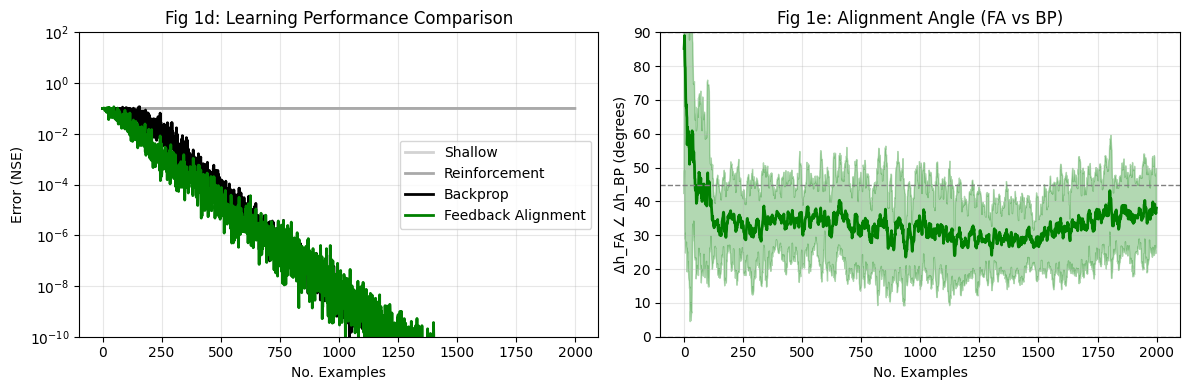

In [1]:
results, algorithms, colors = linear_task_experiment(n_examples=2000)
plot_linear_task_results(results, algorithms, colors)